<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# A Guide to Load & Visualize the Crop Data

This notebook walks you through the steps to get access to Radiant MLHub and download and explore the Kenya Crop dataset. These notebooks were originally developed for the CV4A ICRL Crop Type Classification Challenge, which was a part of the [CV4A](https://www.cv4gc.org/cv4a2020/) workshop at 2020 ICLR. 

To download the data needed to run this notebook, please see `cv4a-crop-challenge-download-data` in this same repository.

In [1]:
# Import required libraries
from pathlib import Path
from glob import glob

from tqdm.notebook import tqdm
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

%matplotlib inline

In [2]:
# Define path to the source collection that was extracted from the dataset download in previous notebook
collection_path = Path('./data/ref_african_crops_kenya_02/ref_african_crops_kenya_02_source')

In [3]:
def load_file(img_path):
    """Takes a path to the download archive and the path within the archive to the image and returns a numpy array."""
    
    return tiff.imread(str(img_path))

In [4]:
# Get a list of dates that an observation from Sentinel-2 is provided for from the downloaded imagery

tile_dates = dict()

def filter_tifs(name):
    return name.endswith('.tif')

for f in glob(str(collection_path / '**/*.json')):
    tif_path = Path(f)
    _, tile_id, tile_date = tif_path.parent.name.rsplit('_', 2)

    if tile_id not in tile_dates:
        tile_dates[tile_id] = set()

    tile_dates[tile_id].add(tile_date)

In [5]:
for tile in sorted(tile_dates.keys()):
    print(f'Tile ID: {tile}')
    dates = sorted(list(tile_dates[tile]))
    print(f'Dates: {", ".join(dates)}')
    print('')

Tile ID: 00
Dates: 20190606, 20190701, 20190706, 20190711, 20190721, 20190805, 20190815, 20190825, 20190909, 20190919, 20190924, 20191004, 20191103

Tile ID: 01
Dates: 20190606, 20190701, 20190706, 20190711, 20190721, 20190805, 20190815, 20190825, 20190909, 20190919, 20190924, 20191004, 20191103

Tile ID: 02
Dates: 20190606, 20190701, 20190706, 20190711, 20190721, 20190805, 20190815, 20190825, 20190909, 20190919, 20190924, 20191004, 20191103

Tile ID: 03
Dates: 20190606, 20190701, 20190706, 20190711, 20190721, 20190805, 20190815, 20190825, 20190909, 20190919, 20190924, 20191004, 20191103



In [6]:
# Create a list of all available bands
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLD']

In [7]:
# Define sample file to load
tile = '02'
date_ = '20190825'
band = 'B03'

archive_path = "./data/ref_african_crops_kenya_02_source.tar.gz"
img_path = collection_path / f"ref_african_crops_kenya_02_tile_{tile}_{date_}/{band}.tif"
band_data = load_file(img_path)

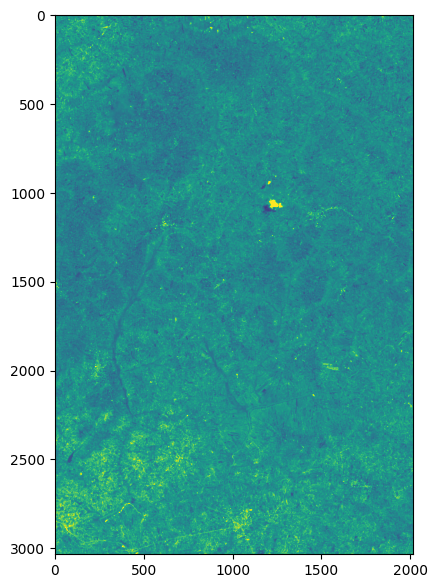

In [8]:
# Plot sample image
fig = plt.figure(figsize=(7, 7))
plt.imshow(band_data, vmin=0, vmax=0.15)

## Time Series Loading and Band Visualizations

### Load time series as numpy array

In [9]:
selected_tile = list(tile_dates.keys())[0]
dates = sorted(tile_dates[selected_tile])

bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLD']
def load_image(date):
    img = list()
    for band in bands:
        img_path = collection_path / f"ref_african_crops_kenya_02_tile_{selected_tile}_{date}/{band}.tif"
        img.append(load_file(img_path))
    return np.dstack(img)

def load_timeseries():
    tstack = list()
    with tqdm(dates, total=len(dates), desc="reading images") as pbar:
        for date in pbar:
            tstack.append(load_image(date))
    return np.stack(tstack) 

timeseries = load_timeseries()
print(timeseries.shape)

reading images:   0%|          | 0/13 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michelleroby/radiant-earth/mlhub-tutorials/notebooks/2020 CV4A Crop Type Challenge/data/ref_african_crops_kenya_02/ref_african_crops_kenya_02_source/ref_african_crops_kenya_02_tile_00_20190606/B01.tif'

In [ ]:
# List of Sentinel-2 bands in the dataset

rgb = np.array(['B04','B03', 'B02'])
rgb_idx = [bands.index(b) for b in rgb]
rgb_stack = timeseries[:,:,:,rgb_idx]

false_color = np.array(['B08','B04', 'B03'])
false_color_idx = [bands.index(b) for b in false_color]
false_color_stack = timeseries[:,:,:,false_color_idx]

perc_rgb = np.percentile(rgb_stack.mean(2), (10, 90))
perc_false_color = np.percentile(np.median(false_color_stack,axis=2), (2, 98))

red = timeseries[:,:,:,bands.index("B04")]
nir = timeseries[:,:,:,bands.index("B08")]
ndvi = (red-nir) / (red+nir)

fig,axs = plt.subplots(len(dates),3,figsize=(15,len(dates)*8))

with tqdm(range(len(dates)),total=len(dates)) as pbar:
    for date_idx in pbar:

        ax = axs[date_idx,0]
        rgb_img = rgb_stack[date_idx]
        rgb_img = exposure.rescale_intensity(rgb_img, in_range=(perc_rgb[0],perc_rgb[1]))
        ax.imshow(rgb_img)
        ax.axis('off')
        dt = dates[date_idx]
        ax.set_title(f"RGB {dt} {rgb}")

        ax = axs[date_idx,1]
        false_color_img = false_color_stack[date_idx]
        false_color_img = exposure.rescale_intensity(false_color_img, in_range=(perc_false_color[0],perc_false_color[1]))
        ax.imshow(false_color_img)
        ax.axis('off')
        dt = dates[date_idx]
        ax.set_title(f"False-Color {dt} {false_color}")

        ax = axs[date_idx,2]
        ndvi_img = ndvi[date_idx]
        ax.imshow(ndvi_img, cmap="Greens_r")
        ax.axis('off')
        dt = dates[date_idx]
        ax.set_title(f"NDVI {dt} (B08-B04)/(B08+B04)")

fig.tight_layout()